In [ ]:
import logging
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger

from calvera.benchmark.datasets.movie_lens import MovieLensDataset
from calvera.bandits.neural_ts_bandit import NeuralTSBandit
from calvera.utils.selectors import TopKSelector
from calvera.benchmark.environment import BanditBenchmarkEnvironment
from calvera.benchmark.logger_decorator import OnlineBanditLoggerDecorator
from calvera.utils.data_storage import InMemoryDataBuffer, AllDataBufferStrategy
from calvera.benchmark.datasets.synthetic_combinatorial import SyntheticCombinatorialDataset

c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))


class LinearNetwork(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        return self.fc(x)


Context shape: torch.Size([20, 40])
Reward shape: torch.Size([20])

Rewards: [0.0020770870614796877, 0.0002827113785315305, 0.00019448563398327678, 0.00011013360199285671, 0.0033507372718304396, 0.00674970680847764, 0.013129100203514099, 0.022062569856643677, 7.051158172544092e-05, 0.01332011166960001, 0.08211074024438858, 0.013809540309011936, 0.04551730677485466, 0.06853374093770981, 0.009268393740057945, 0.006984720006585121, 0.08128179609775543, 0.01682909205555916, 0.006417924538254738, 0.00024968283833004534]

Top 4 arms: [10, 16, 13, 12]
Top 4 rewards: [0.08211074024438858, 0.08128179609775543, 0.06853374093770981, 0.04551730677485466]


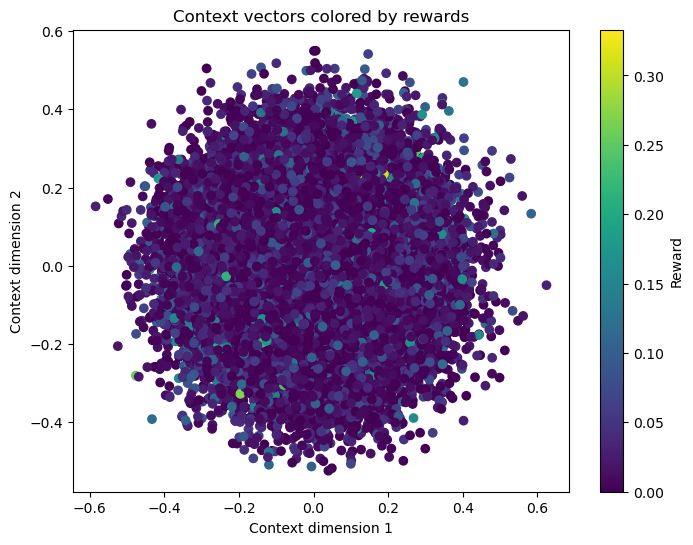

In [3]:
dataset = SyntheticCombinatorialDataset(
    n_samples=2000, num_actions=20, context_size=40, function_type="quadratic", noise_std=0, seed=42
)

contexts, rewards = dataset[0]
print(f"\nContext shape: {contexts.shape}")
print(f"Reward shape: {rewards.shape}")

print(f"\nRewards: {rewards[:].tolist()}")

K = 4
top_k_indices = torch.topk(rewards, K).indices
print(f"\nTop {K} arms: {top_k_indices.tolist()}")
print(f"Top {K} rewards: {rewards[top_k_indices].tolist()}")

# plot first two dimensions of X and color by y
plt.figure(figsize=(8, 6))
plt.scatter(
    dataset.contexts.view(-1, dataset.context_size)[:, 0],
    dataset.contexts.view(-1, dataset.context_size)[:, 1],
    c=dataset.rewards.view(-1, dataset.context_size)[:],
    cmap="viridis",
)
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")

In [ ]:
dataset = MovieLensDataset(version="ml-32m")

K = 4

train_loader = DataLoader(Subset(dataset, range(2000)), batch_size=100, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)

buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=None,
)

# buffer = InMemoryDataBuffer(
#     buffer_strategy=SlidingWindowBufferStrategy(window_size=200),
# )

network = Network(dataset.context_size, hidden_size=100)
# network = LinearNetwork(dataset.context_size)

bandit_module = NeuralTSBandit(
    n_features=dataset.context_size,
    network=network,
    selector=TopKSelector(k=K),
    buffer=buffer,
    train_batch_size=100,
    early_stop_threshold=1e-4,
    weight_decay=1e-4,
    exploration_rate=1,
    learning_rate=1e-2,
    min_samples_required_for_training=1,
    initial_train_steps=0,
    num_samples_per_arm=10,
)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logging.getLogger("neural_bandits.bandits.abstract_bandit").setLevel(logging.FATAL)
logging.getLogger("neural_bandits.bandits.neural_bandit").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(
    CSVLogger("logs", name="combinatorial_neural_ucb_bandit", flush_logs_every_n_steps=100),
    enable_console_logging=False,
)

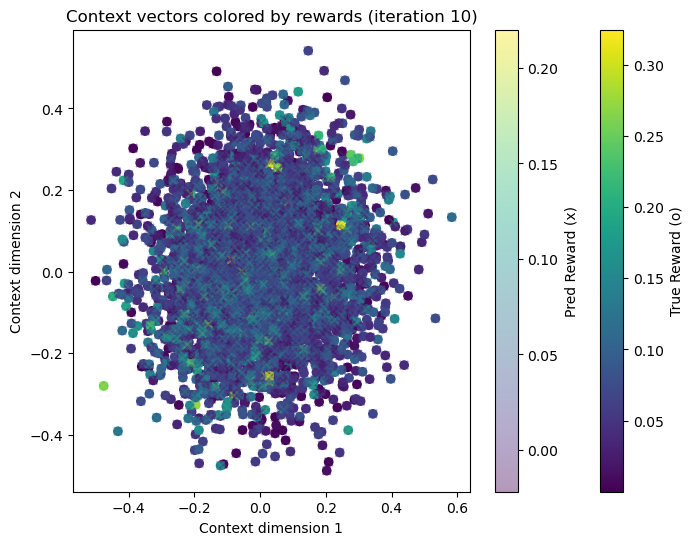

100%|██████████| 20/20 [00:41<00:00,  2.07s/it, acc_regret=73.3, avg_regret=0.0367, regret=0.00192, reward=0.278]


,reward,regret
0,0.102667,0.163170
1,0.275795,0.293099
2,0.057835,0.207063
3,0.118679,0.239605
4,0.204678,0.148263


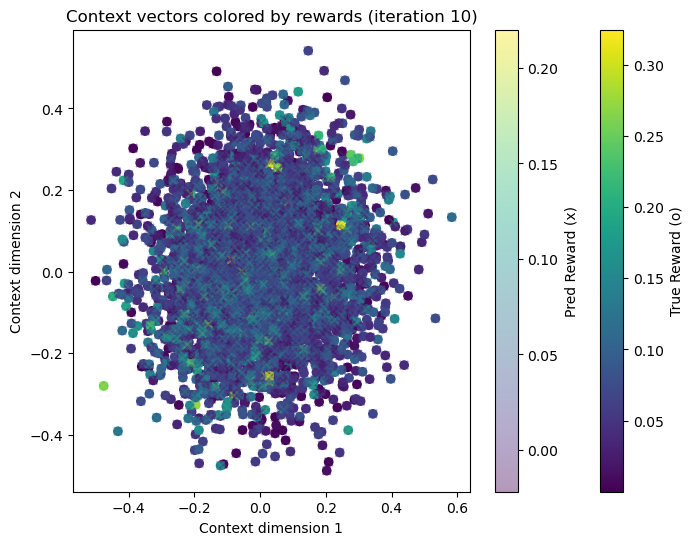

In [5]:
rewards = np.array([])
regrets = np.array([])
progress_bar = tqdm(enumerate(env), total=len(env))

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter([], [], c=[], cmap="viridis")
cbar = fig.colorbar(scatter, ax=ax, label="True Reward (o)")
cbar2 = fig.colorbar(scatter, ax=ax, label="Pred Reward (x)")

for i, contextualized_actions in progress_bar:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(
        max_epochs=1,
        max_steps=1000,
        logger=logger,
        gradient_clip_val=20.0,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
    )

    chosen_contextualized_actions, realized_scores = env.get_feedback(chosen_actions)
    realized_rewards = realized_scores.sum(dim=1)
    batch_regret = env.compute_regret(chosen_actions)

    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    progress_bar.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=np.mean(regrets),
        acc_regret=np.sum(regrets),
    )

    bandit_module.record_feedback(chosen_contextualized_actions, realized_scores)
    trainer.fit(bandit_module)

    pred_y = bandit_module.theta_t(buffer.contextualized_actions).detach().numpy()

    if i % 10 == 0:
        ax.clear()

        scatter_true = ax.scatter(
            buffer.contextualized_actions[:, 0, 0],
            buffer.contextualized_actions[:, 0, 1],
            c=buffer.rewards,
            cmap="viridis",
            marker="o",
            label="True Rewards",
            alpha=1.0,
        )

        # Plot first two dimensions of X and color by y
        scatter_pred = ax.scatter(
            buffer.contextualized_actions[:, 0, 0],
            bandit_module.buffer.contextualized_actions[:, 0, 1],
            c=pred_y,
            marker="x",
            cmap="viridis",
            alpha=0.4,
        )  # type: ignore
        ax.set_xlabel("Context dimension 1")
        ax.set_ylabel("Context dimension 2")
        ax.set_title(f"Context vectors colored by rewards (iteration {i})")

        cbar.update_normal(scatter_true)
        cbar2.update_normal(scatter_pred)

        clear_output(wait=True)
        display(fig)

metrics = pd.DataFrame(
    {
        "reward": rewards,
        "regret": regrets,
    }
)

metrics.head()

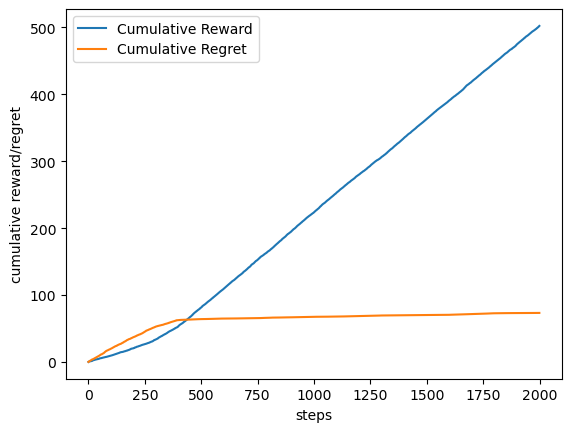

In [6]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative reward and regret
plt.plot(cumulative_reward, label="Cumulative Reward")
plt.plot(cumulative_regret, label="Cumulative Regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [7]:
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.1096
Average reward (first 100 rounds): 0.0942
Average reward (all rounds): 0.2511

Average regret (first 10 rounds): 0.2023
Average regret (first 100 rounds): 0.1973
Average regret (all rounds): 0.0367


logs\combinatorial_neural_ucb_bandit\version_53/metrics.csv


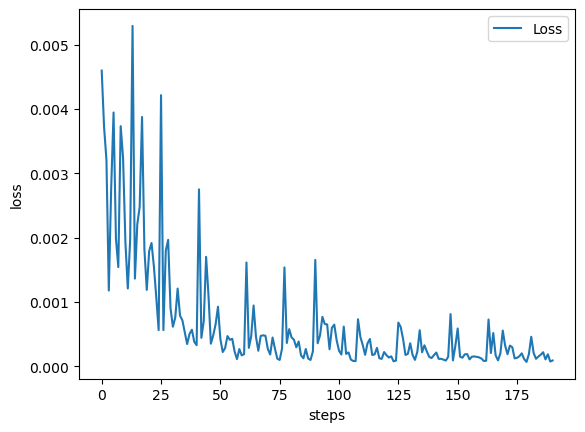

In [8]:
bandit_metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(bandit_metrics_csv)
bandit_metrics = pd.read_csv(bandit_metrics_csv)

plt.plot(bandit_metrics["loss"][:10000].dropna(), label="Loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()